## Setting Up

In [ ]:
from IPython.display import display, Javascript, Audio
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
import io

In [ ]:
from IPython import get_ipython

In [ ]:
import re

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive, output

In [ ]:
!pip install gtts

In [ ]:
from gtts import gTTS

In [ ]:
!pip install torch torchvision opencv-python

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 10.4 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

In [ ]:
!pip install pytesseract

In [ ]:
from IPython.utils import io
import pytesseract

## Streaming Functions

In [ ]:
# Function to handle JavaScript message
def handle_js_message(msg):
    global flag
    if msg['content']['data']['flag'] == 1:
        flag = 1
        print("Flag set to 1 by JavaScript")

# Register the message handler
get_ipython().kernel.comm_manager.register_target('flag_comm', handle_js_message)

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        var flag = 0;

        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            const stop = document.createElement('button');
            stop.textContent = 'Stop';
            const returnEmpty = document.createElement('button');
            returnEmpty.textContent = 'Space';
            div.appendChild(capture);
            div.appendChild(stop);
            div.appendChild(returnEmpty);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            let photoData = null;

            capture.onclick = () => {
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                photoData = canvas.toDataURL('image/jpeg', quality);
                stream.getVideoTracks()[0].stop();
                div.remove();
            };

            stop.onclick = () => {
                stream.getVideoTracks()[0].stop();
                div.remove();
                flag = 1;
                google.colab.kernel.invokeFunction('flag_comm', {flag: 1}, {});
            };

            returnEmpty.onclick = () => {
                stream.getVideoTracks()[0].stop();
                div.remove();
                flag = 2;
                google.colab.kernel.invokeFunction('flag_comm', {flag: 2}, {});
            };

            // Wait for either the capture or stop button to be clicked
            while (!photoData && !flag) {
                await new Promise(resolve => setTimeout(resolve, 100));
            }

            return {photoData: photoData, flag: flag};
        }
    ''')
    display(js)
    result = eval_js('takePhoto({})'.format(quality))

    if result['flag'] == 1:
        #print("Video stream stopped without capturing a photo.")
        global flag
        flag = 1
        return None
    elif result['flag'] == 2:
        print("Space")
        flag = 2
        return " "

    if result['photoData'] is None:
        #print("No photo captured.")
        return None

    binary = b64decode(result['photoData'].split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

def stop_stream():
    js = Javascript('''
        function stopStream() {
            const videoElements = document.querySelectorAll('video');
            videoElements.forEach(video => {
                const stream = video.srcObject;
                const tracks = stream.getTracks();

                tracks.forEach(track => track.stop());
                video.remove();
            });
            google.colab.kernel.invokeFunction('flag_comm', {flag: 1}, {});
        }
        stopStream();
    ''')
    display(js)

## Text-to-Speech

In [ ]:
#function
def say(text, speech_file_path):
    tts = gTTS(text=text, lang='ar')

    # Save the audio to a file
    tts.save(speech_file_path)

## Important Functions

In [ ]:
def contains_letter(s):
    # Arabic Unicode range: \u0600-\u06FF
    return bool(re.search('[\u0600-\u06FF]', s))

## Main Program

Firstly, Upload the model 'ASL.pt' to the workspace.

In [ ]:
# Load the model
model = YOLO('ASL.pt')

In [ ]:
mapping = {'ain':'ع',
           'al':'ال',
           'aleff':'ا',
           'bb':'ب',
           'dal':'د',
           'dha':'ظ',
           'dhad':'ض',
           'fa':'ف',
           'gaaf':'ق',
           'ghain':'غ',
           'ha':'ه',
           'haa':'ه',
           'jeem':'ج',
           'kaaf':'ك',
           'khaa':'خ',
           'la':'لا',
           'laam':'ل',
           'meem':'م',
           'nun':'ن',
           'ra':'ر',
           'saad':'ص',
           'seen':'س',
           'sheen':'ش',
           'ta':'ت',
           'taa':'ط',
           'thaa':'ث',
           'thal':'ذ',
           'toot':'ة',
           'waw':'و',
           'ya':'ي',
           'yaa':'ي',
           'zay':'ز'}

<IPython.core.display.Javascript object>

requirements: Ultralytics requirement ['lapx>=0.5.2'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.2s, installed 1 package: ['lapx>=0.5.2']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


0: 192x256 1 meem, 249.5ms
Speed: 19.1ms preprocess, 249.5ms inference, 36.1ms postprocess per image at shape (1, 3, 192, 256)


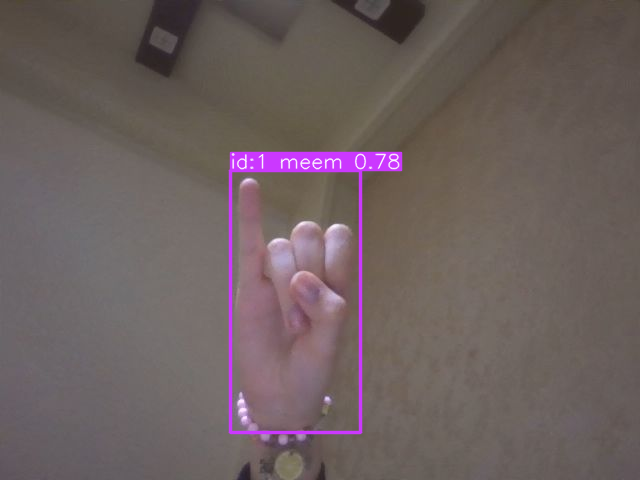

م


<IPython.core.display.Javascript object>


0: 192x256 1 yaa, 108.0ms
Speed: 1.6ms preprocess, 108.0ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 256)


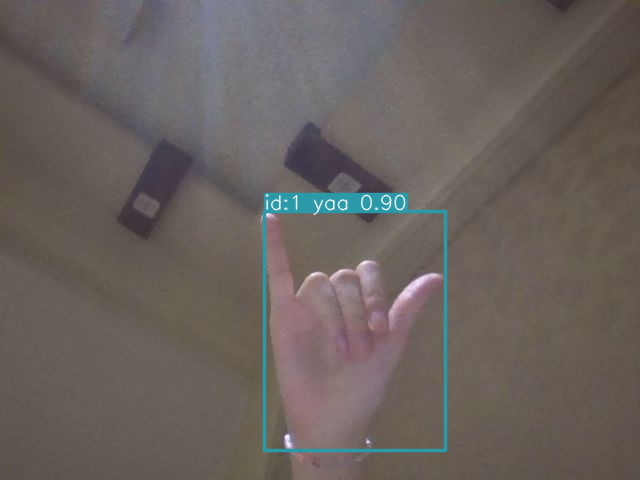

ي


<IPython.core.display.Javascript object>

مي


In [ ]:
# Global flag
flag = 0

all = ''

while(flag != 1):
  image_file = take_photo()
  if image_file != None and image_file != ' ':

      # Convert to OpenCV format
      frame = cv2.imread(image_file)

      results = model.track(frame, persist=True)
      #text = results[0]
      # print(results[0].__str__)
      annotated_frame = results[0].plot()
      stri = results[0].verbose()
      #print(stri)
      if (stri != "(no detections), "):
        #print(stri)

        # Display the image with the prediction
        #image = Image.fromarray(annotated_frame)
        #display(image)
        words = stri.split()
        predicted_class = mapping[words[1][:-1]]
        all = all + predicted_class
        # Display the prediction on the image
        #cv2.putText(annotated_frame, words[1], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
      else:
        predicted_class = 'no detections'

        # Display the prediction on the image
        cv2.putText(annotated_frame, predicted_class, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

      # Convert the image to RGB format for displaying
      image_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

      # Display the image with the prediction
      display(Image.fromarray(image_rgb))

      print(predicted_class)

  elif (flag == 2):
      all = all + " "
  else:
      print(all)
      # Display Audio
      if contains_letter(all):
        voice = say(all, "voice.mp3")
        display(Audio("voice.mp3", autoplay=True))